In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc

import gym
from mountaincar import MountainCarEnv

In [2]:
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [3]:
import warnings 
warnings.filterwarnings('ignore')

## Explore The Environment

In [4]:
env = MountainCarEnv(); env.seed(90);

Environment Display:
State space Box(2,)
Action space Discrete(3)
Final score: -200.0


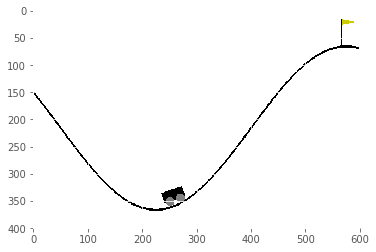

In [5]:
print('Environment Display:')

state = env.reset() # reset environment to a new, random state
score = 0

num_episodes = 200 # limit of moves in this environment
for time_step in range(num_episodes):
    
    action = env.action_space.sample()
    env.render()
    next_state, reward, done, _ = env.step(action) # a -1 reward is applied for each move taken (including doing nothing)
    score += reward
    
    state = next_state
    if done:
        break

print('State space', env.observation_space)
print('Action space', env.action_space)
print('Final score:', score)
plt.imshow(env.render(mode='rgb_array'))
plt.show()

env.close()

In [6]:
# explore state (observation) space
print('State space:', env.observation_space)
print(f'- Position: {env.observation_space.low[0]} {env.observation_space.high[0]}')
print(f'- Velocity: {env.observation_space.low[1]} {env.observation_space.high[1]}')

State space: Box(2,)
- Position: -1.2000000476837158 0.6000000238418579
- Velocity: -0.07000000029802322 0.07000000029802322


In [7]:
# explore the action space
print("Action space:", env.action_space)
print('0 Push left')
print('1 No push')
print('2 Push right')

Action space: Discrete(3)
0 Push left
1 No push
2 Push right


## Discretize the State Space with a Uniform Grid

In [8]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space."""
    
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    return grid

In [9]:
def discretize(sample, grid):
    """Discretize a sample as per given grid."""
    
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))

In [10]:
low = [-1.0, -5.0]
high = [1.0, 5.0]

In [11]:
grid = create_uniform_grid(low, high, bins=(10, 10))
state_samples = np.array([[-0.8 , -4.8], [-0.81, -4.1], [-0.8 , -4.0], [-0.5 ,  0.0], 
                          [ 0.2 , -1.9], [ 0.8 ,  4.0], [ 0.81,  4.1], [ 0.73 ,  4.32]])

discretized_samples = np.array([discretize(sample, grid) for sample in state_samples])

## Visualize The Discritization

In [12]:
def visualize_discretized_samples(samples, discretized_samples, grid, low=None, high=None, env=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # if bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # otherwise use first, list grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]
        
    # map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples
    
    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])
    
    if env == 'mountaincar':
        # axis labels for MountainCar-v0 state space
        plt.xlabel('position'); plt.ylabel('velocity');
    else:
        plt.xlabel('x-axis (state 1)'); plt.ylabel('y-axis (state 2)');
    
    return ax

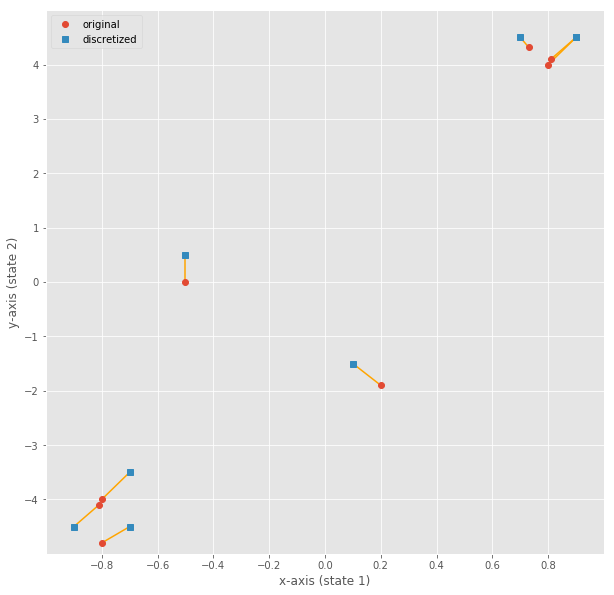

In [13]:
ax = visualize_discretized_samples(state_samples, discretized_samples, grid, low, high); plt.show()

## Apply The Uniform Grid

In [14]:
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))

In [15]:
# obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for _ in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])

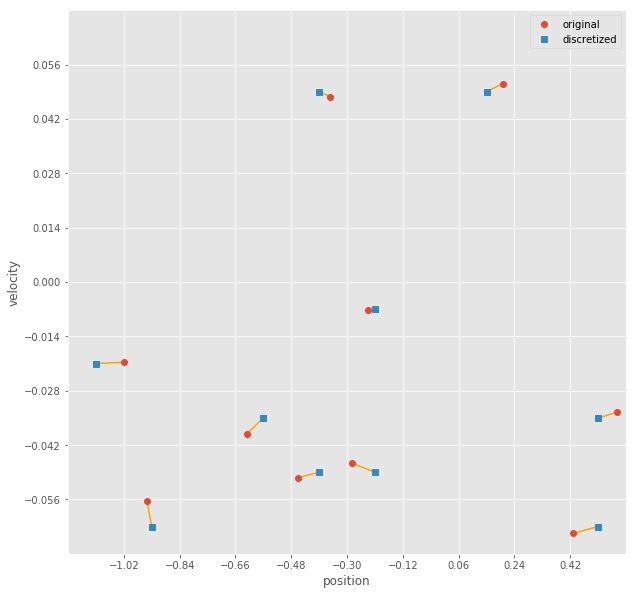

In [16]:
ax = visualize_discretized_samples(state_samples, discretized_state_samples, state_grid, 
                                   env.observation_space.low, env.observation_space.high, env='mountaincar'); plt.show()

## Define Q-Learning Agent

In [17]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""
    
    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99, 
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""        
        
        # environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid) # n-dimensional state space
        self.action_size = self.env.action_space.n # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        
        print('Environment:', self.env)
        print('State space size:', self.state_size)
        print('Action space size:', self.action_size)
        
        # learning parameters
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.epsilon = self.initial_epsilon = epsilon # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
    
        # init Q-table
        self.Q_table = np.zeros(shape=(self.state_size + (self.action_size, )))
        print('Q-table size:', self.Q_table.shape)
        
    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        
        return tuple(discretize(state, self.state_grid))
    
    def reset_episode(self, state):
        """Reset variables for a new episode."""
        
        # gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        # decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.Q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
    
    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        
        state = self.preprocess_state(state)
        if mode == 'test':
            # test mode: simply produce an action
            action = np.argmax(self.Q_table[state])
        else:
            # train mode (default): update Q-table, pick the next action
            # note: we update the Q-table entry for the last (state, action) pair with current state, reward
            self.Q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.Q_table[state]) - self.Q_table[self.last_state + (self.last_action,)])
            
            # exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # pick the best action from Q-table
                action = np.argmax(self.Q_table[state])
                
        # roll over current state, action for the next step
        self.last_state = state
        self.last_action = action
        return action

In [18]:
Q_agent = QLearningAgent(env, state_grid)

Environment: <MountainCarEnv instance>
State space size: (10, 10)
Action space size: 3
Q-table size: (10, 10, 3)


## Train The Agent

In [19]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        
        # initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False
        
        # roll out steps until done
        while not done:
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(next_state, reward, done, mode)
            
            state = next_state
        
        # save final score
        scores.append(total_reward)
        
        # print episode status
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
                    
            if i_episode % 1 == 0:
                print('\rEpisode {i_episode}/{num_episodes} | Max Average Score: {max_avg_score}', end='')
                sys.stdout.flush()
    return scores

In [20]:
scores = run(Q_agent, env)

Episode 20000/20000 | Max Average Score: -125.95

## Evaluate The Agent

In [21]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    
    # filter out very low scores obtained
    scores = [score for score in scores if score > np.mean(scores)]
    
    plt.figure(figsize=(10, 5))
    
    plt.plot(scores)
    plt.title('Scores')
    plt.xlabel('Number of episodes')
    plt.ylabel('Total of collected rewards')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    
    plt.show()
    return rolling_mean

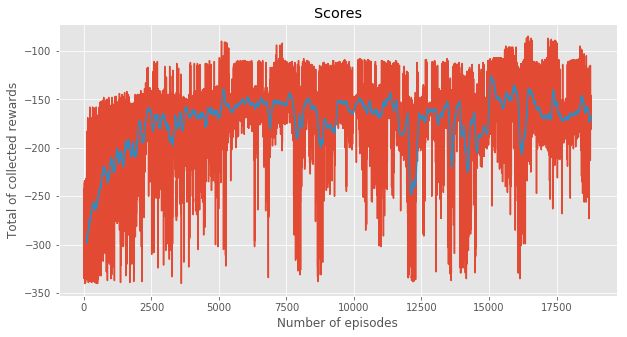

In [22]:
rolling_mean = plot_scores(scores)

## Test The Agent

In [23]:
# run in test mode and analyze scores obtained
test_scores = run(Q_agent, env, num_episodes=100, mode='test')

[TEST] Completed 100 episodes with avg. score = -155.91


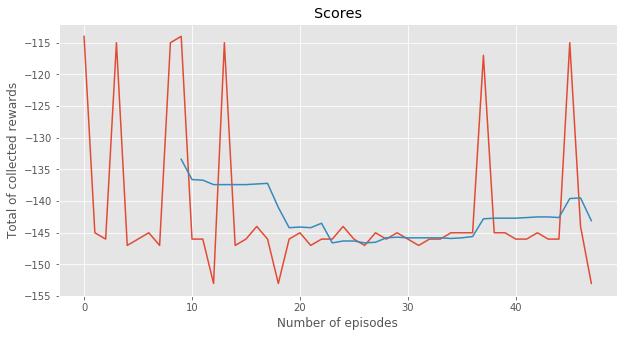

In [24]:
print(f'[TEST] Completed {len(test_scores)} episodes with avg. score = {np.mean(test_scores)}')
rolling_mean = plot_scores(test_scores, rolling_window=10)

## Visualize Q-table

In [25]:
def plot_Q_table(Q_table):
    """Visualize max Q-value for each state and corresponding action."""
    Q_image = np.max(Q_table, axis=2) # max Q-value for each state
    Q_actions = np.argmax(Q_table, axis=2) # best action for each state
    
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(Q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    for x in range(Q_image.shape[0]):
        for y in range(Q_image.shape[1]):
            ax.text(x, y, Q_actions[x, y], color='white', 
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title(f'Q-table, size: {Q_table.shape}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    
    plt.show()

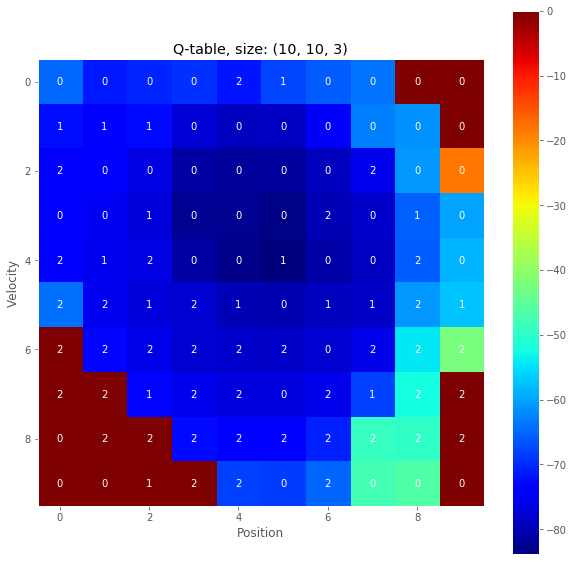

In [26]:
plot_Q_table(Q_agent.Q_table)

## Watch The Agent

In [27]:
print('Environment Display:')
state = env.reset() # reset environment to a new, random state
score = 0

num_episodes = 200
for time_step in range(num_episodes):
    
    action = Q_agent.act(state, mode='test')
    env.render()
    next_state, reward, done, _ = env.step(action)
    score += reward
    
    state = next_state
    if done:
        break
        
print('Final score:', score)
env.close()

Environment Display:
Final score: -166.0


## Modify The Finer Grid

In [28]:
# create a new agent with a different state space grid
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(20, 20))
Q_smart_agent = QLearningAgent(env, state_grid)

Environment: <MountainCarEnv instance>
State space size: (20, 20)
Action space size: 3
Q-table size: (20, 20, 3)


Episode 50000/50000 | Max Average Score: -108.65

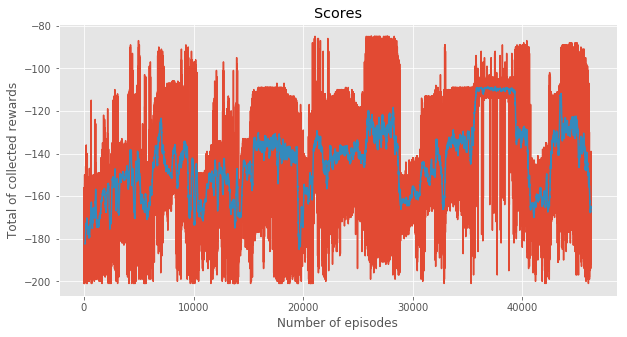

In [29]:
# init a list to store scores for the agent
Q_smart_agent.scores = []

# train it over a desired number of episodes and analyze scores
Q_smart_agent.scores += run(Q_smart_agent, env, num_episodes=50000) # accumulate scores
rolling_mean = plot_scores(Q_smart_agent.scores)

[TEST] Completed 100 episodes with avg. score = -164.49


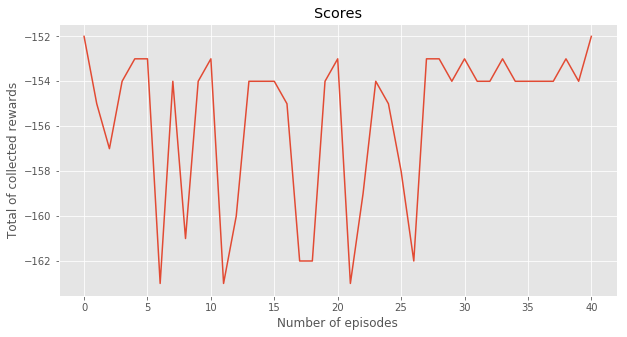

In [30]:
# run in test mode and analyze scores obtained
test_scores = run(Q_smart_agent, env, num_episodes=100, mode='test')
print(f'[TEST] Completed {len(test_scores)} episodes with avg. score = {np.mean(test_scores)}')
rolling_mean = plot_scores(test_scores)

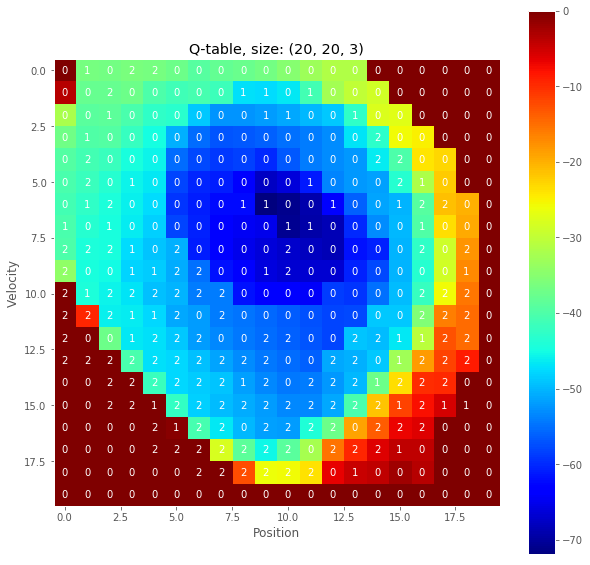

In [31]:
# visualize the learned Q-table
plot_Q_table(Q_smart_agent.Q_table)

## Watch The Smart Agent

In [32]:
print('Environment Display:')
state = env.reset() # reset environment to a new, random state
score = 0

num_episodes = 200
for time_step in range(num_episodes):
    
    action = Q_smart_agent.act(state, mode='test')
    env.render()
    next_state, reward, done, _ = env.step(action)
    score += reward
    
    state = next_state
    if done:
        break
        
print('Final score:', score)
env.close()

Environment Display:
Final score: -154.0


---